In [1]:
# ============================================================
# 1. Install DeepXDE (run once in Colab)
# ============================================================
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.4 MB/s eta 0:00:00


In [2]:
# ============================================================
# 2. Imports & backend
#    Supported: tensorflow.compat.v1, tensorflow, pytorch, paddle
# ============================================================
import deepxde as dde
import numpy as np

dde.backend.set_default_backend("tensorflow")

No backend selected.
Finding available backend...
Found tensorflow
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [3]:
# ============================================================
# 3. Problem parameters
# ============================================================
a = 0.4   # Thermal diffusivity
L = 1.0   # Length of the bar
n = 1     # Frequency of sinusoidal initial condition

# ============================================================
# 4. Exact solution (for evaluation)
# ============================================================
def heat_eq_exact_solution(x, t):
    return np.exp(-(n**2 * np.pi**2 * a * t) / (L**2)) * np.sin(
        n * np.pi * x / L
    )


In [4]:
# ============================================================
# 5. Generate exact solution data (optional but useful)
# ============================================================
def gen_exact_solution():
    x_dim, t_dim = 256, 201
    x = np.linspace(0, L, x_dim).reshape(-1, 1)
    t = np.linspace(0, 1.0, t_dim).reshape(-1, 1)

    usol = np.zeros((x_dim, t_dim))
    for i in range(x_dim):
        for j in range(t_dim):
            usol[i, j] = heat_eq_exact_solution(x[i], t[j])

    np.savez("heat_eq_data.npz", x=x, t=t, usol=usol)

def gen_testdata():
    data = np.load("heat_eq_data.npz")
    x, t, exact = data["x"], data["t"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((xx.ravel(), tt.ravel())).T
    y = exact.flatten()[:, None]
    return X, y

# Generate exact dataset
gen_exact_solution()

/tmp/ipython-input-4044238965.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  usol[i, j] = heat_eq_exact_solution(x[i], t[j])


In [5]:
# ============================================================
# 6. Heat equation PDE
#     u_t − a u_xx = 0
# ============================================================
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - a * dy_xx


In [6]:
# ============================================================
# 7. Geometry & time domain
# ============================================================
geom = dde.geometry.Interval(0.0, L)
timedomain = dde.geometry.TimeDomain(0.0, 1.0)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [7]:
# ============================================================
# 8. Boundary & initial conditions
# ============================================================
# Dirichlet BC: u(0,t)=u(L,t)=0
bc = dde.icbc.DirichletBC(
    geomtime,
    lambda x: 0,
    lambda _, on_boundary: on_boundary,
)

# Initial condition: u(x,0)=sin(nπx/L)
ic = dde.icbc.IC(
    geomtime,
    lambda x: np.sin(n * np.pi * x[:, 0:1] / L),
    lambda _, on_initial: on_initial,
)

In [8]:
# ============================================================
# 9. Data object
# ============================================================
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)

In [15]:
# ============================================================
# 10. Neural network
# ============================================================
net = dde.nn.FNN(
    [2] + [20] * 3 + [1],
    activation="tanh",
    kernel_initializer="Glorot uniform",
)

In [18]:
# ============================================================
# 9. Model compilation
# ============================================================
model = dde.Model(data, net)
model.compile(
    optimizer="adam",
    lr=0.001,
)


Compiling model...
'compile' took 0.013393 s



In [19]:
# ============================================================
# 10. Train
# ============================================================
losshistory, train_state = model.train(iterations=10000)

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.12e-01, 1.46e-01, 8.66e-01]    [1.12e-01, 1.46e-01, 8.66e-01]    []  
1000      [2.78e-03, 3.19e-03, 2.77e-03]    [1.73e-03, 3.19e-03, 2.77e-03]    []  
2000      [7.70e-04, 2.91e-04, 1.52e-04]    [4.25e-04, 2.91e-04, 1.52e-04]    []  
3000      [1.86e-04, 5.75e-05, 2.53e-05]    [1.02e-04, 5.75e-05, 2.53e-05]    []  
4000      [9.37e-05, 3.01e-05, 1.08e-05]    [5.47e-05, 3.01e-05, 1.08e-05]    []  
5000      [6.12e-05, 1.96e-05, 4.42e-06]    [3.77e-05, 1.96e-05, 4.42e-06]    []  
6000      [9.27e-05, 2.21e-05, 4.30e-05]    [6.70e-05, 2.21e-05, 4.30e-05]    []  
7000      [3.76e-05, 9.56e-06, 1.41e-06]    [2.48e-05, 9.56e-06, 1.41e-06]    []  
8000      [4.34e-05, 1.49e-05, 1.30e-05]    [3.30e-05, 1.49e-05, 1.30e-05]    []  
9000      [2.74e-05, 5.60e-06, 5.19e-07]    [1.85e-05, 5.60e-06, 5.19e-07]    []  
10000     [2.39e-05, 4.54e-06, 3.74e-07]    [1.62e-05, 4.54e-

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


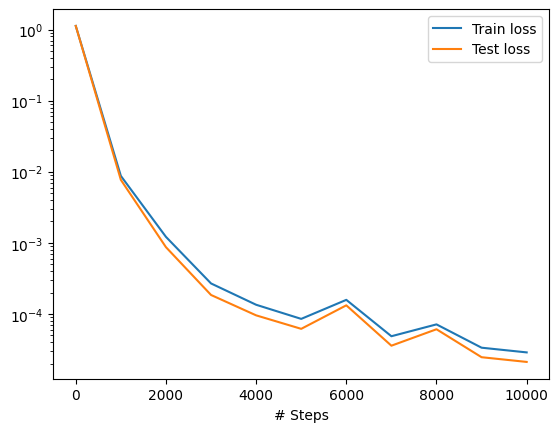

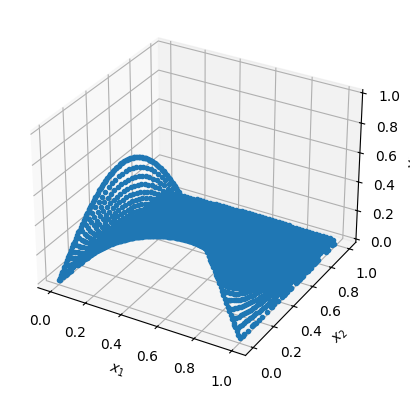

In [20]:
# ============================================================
# 11. Save and plot results
# ============================================================
dde.saveplot(losshistory, train_state, issave=True, isplot=True)